##Bursi dataset

In [5]:
%matplotlib inline
import time
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LSHForest
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import neighborsMinHash as kneighbors
from neighborsMinHash.util import create_dataset
from neighborsMinHash.util import create_dataset_fixed_nonzero
from neighborsMinHash.util import measure_performance
from neighborsMinHash.util import plotData


import random

from scipy.sparse import dok_matrix
from scipy.sparse import rand
from scipy.sparse import vstack


import pyflann
import annoy

In [2]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
datasetBursi = vectorizer.transform( graphs )

Computed on Intel i5-2415M 2.3 GHz, 16 GB RAM, Mac OS X 10.11 El Capitan

In [ ]:
n_neighbors_sklearn = 5
n_neighbors_minHash = 5
returnValuesBursi = measure_performance([datasetBursi], n_neighbors_sklearn, n_neighbors_minHash, number_of_hashfunctions=8000)

####Query time: 50 calls for a single query

In [ ]:
plotData(data=returnValuesBursi[3:7], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=["bursi"], ylabel="Time in seconds", number_of_instances=1,
        number_of_features=1, title='Query time: 50 calls for a single query')

####Query time: one call for 50 queries

In [ ]:
plotData(data=returnValuesBursi[7:13], color=["r", "b", "m", "g", "c"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf", "annoy"],
        xticks=["bursi"], ylabel="Time in seconds", number_of_instances=1,
        number_of_features=1, title='Query time: one call for 50 queries')

####Accuracy for bursi dataset

In [ ]:
plotData(data=returnValuesBursi[13:], color=["g", "b", "m", "c"], label=["lhsf", "minHash_exact", "minHash_approx", "annoy"],
        xticks=["bursi"], ylabel="Accuracy", number_of_instances=1,
        number_of_features=1, title='Accuracy', log=False)

####Accuracy vs. number of hash functions
Computed on Intel i7-3770 3.4 GHz, Ubuntu Linux 14.04

In [3]:
precision_minHash_exact = []
precision_minHash_approx = []
time_minHash_exact = []
time_minHash_approx = []
time_minHash_fit = []
size_of_query = 1000
query = None


if size_of_query < datasetBursi.shape[0]:
    query_ids = []
    for i in range(size_of_query):
        query_ids.append(random.randint(0, datasetBursi.shape[0]-1))
    query = datasetBursi[query_ids]
else:
    query = datasetBursi
nearest_neighbor_sklearn = NearestNeighbors(n_neighbors = 5)
nearest_neighbor_sklearn.fit(datasetBursi)
n_neighbors_sklearn = nearest_neighbor_sklearn.kneighbors(X=query,return_distance=False)

hash_functions_list = [50, 100, 200, 400, 800, 1000, 2000, 4000, 8000]
for hash_functions in hash_functions_list:    

    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(n_neighbors = 5,
                                                                  number_of_hash_functions=hash_functions,
                                                                  max_bin_size = 50, minimal_blocks_in_common = 1, 
                                                                  block_size = 4, excess_factor = 5,)

    time_start = time.time()
    nearest_neighbor_minHash.fit(datasetBursi)
    # print nearest_neighbor_minHash._inverseIndex._inverse_index
    time_end = time.time()
    time_minHash_fit.append(time_end - time_start)

    time_start = time.time()
    n_neighbors_minHash_exact = nearest_neighbor_minHash.kneighbors(X=query,return_distance=False)
    time_end = time.time()
    time_minHash_exact.append(time_end - time_start)


    time_start = time.time()
    n_neighbors_minHash_approx = nearest_neighbor_minHash.kneighbors(X=query,fast=True,return_distance=False)
    # print n_neighbors_minHash_approx_1_50
    time_end = time.time()
    time_minHash_approx.append(time_end - time_start)

    accuracy_minHash_exact = np.in1d(n_neighbors_minHash_exact, n_neighbors_sklearn).mean()
    accuracy_minHash_approx = np.in1d(n_neighbors_minHash_approx, n_neighbors_sklearn).mean()
    precision_minHash_exact.append(accuracy_minHash_exact)
    precision_minHash_approx.append(accuracy_minHash_approx)
   
xticksBursi = []
for i in hash_functions_list:
    xticksBursi.append(str(i))

lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False
lazy_fitting:  False


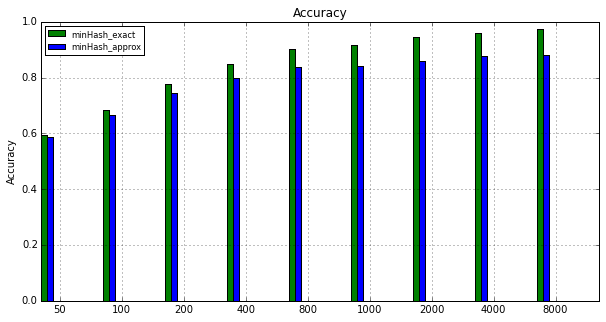

In [6]:
plotData(data=[precision_minHash_exact, precision_minHash_approx], color=["g", "b"], label=["minHash_exact", "minHash_approx"],
        xticks=xticksBursi, ylabel="Accuracy", number_of_instances=len(hash_functions_list),
        number_of_features=1, title='Accuracy', log=False)

####Test the fitting time of single-core vs. multi-core for different number of hash functions
As a dataset "bursi" is used.

In [7]:
import multiprocessing as mp
time_fit = []
time_fit_single_core = []
hash_functions_list = [100, 400, 600, 800, 1000]
for hash_functions in hash_functions_list:    

    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=hash_functions, number_of_cores = mp.cpu_count())
    nearest_neighbor_minHash_single_core = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=hash_functions, number_of_cores=1)

    time_start = time.time()
    nearest_neighbor_minHash.fit(datasetBursi)
    time_end = time.time()
    time_fit.append(time_end - time_start)
    
    time_start = time.time()
    nearest_neighbor_minHash_single_core.fit(datasetBursi)
    time_end = time.time()
    time_fit_single_core.append(time_end - time_start)

xticksBursi = []
for i in hash_functions_list:
    xticksBursi.append(str(i))

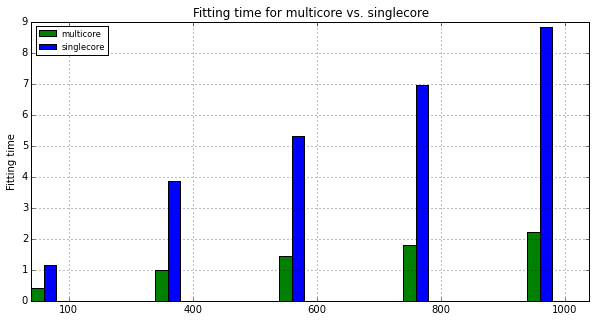

In [8]:
plotData(data=[time_fit, time_fit_single_core], color=["g", "b"], label=["multicore", "singlecore"],
        xticks=xticksBursi, ylabel="Fitting time", number_of_instances=len(hash_functions_list),
        number_of_features=1, title='Fitting time for multicore vs. singlecore', log=False)

####Test the fitting time of single-core vs. multi-core for datasets with different number of instances

In [9]:
import multiprocessing as mp

time_fit = []
time_fit_single_core = []
instances = [100,1000,10000, 100000, 1000000, 10000000]

for instances_ in instances:    
    X, _ = create_dataset(seed=1,
                   number_of_centroids=7,
                   number_of_instances=instances_,
                   number_of_features=100,
                   size_of_dataset=8,
                   density=0.00001,
                   fraction_of_density=0.2
                   )
    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(number_of_cores = mp.cpu_count())
    nearest_neighbor_minHash_single_core = kneighbors.MinHashNearestNeighbors(number_of_cores=1)

    time_start = time.time()
    nearest_neighbor_minHash.fit(X)
    time_end = time.time()
    time_fit.append(time_end - time_start)
    
    time_start = time.time()
    nearest_neighbor_minHash_single_core.fit(X)
    time_end = time.time()
    time_fit_single_core.append(time_end - time_start)
xticksBursi = []
for i in instances:
    xticksBursi.append(str(i))

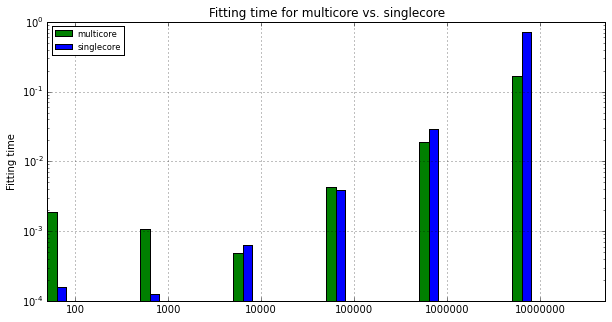

In [10]:
plotData(data=[time_fit, time_fit_single_core], color=["g", "b"], label=["multicore", "singlecore"],
        xticks=xticksBursi, ylabel="Fitting time", number_of_instances=len(instances),
        number_of_features=1, title='Fitting time for multicore vs. singlecore', log=True)